<a href="https://colab.research.google.com/github/SiLiKhon/IMLWorkshop/blob/master/pytorch_ard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install pytorch-ard
#pip install git+https://github.com/rusty1s/pytorch_sparse
pip install git+https://github.com/HolyBayes/pytorch_ard

  Cloning https://github.com/HolyBayes/pytorch_ard to /tmp/pip-req-build-07158ipp
  Cloning https://github.com/rusty1s/pytorch_scatter.git (to revision master) to /tmp/pip-install-8f7ut1tr/pytorch-scatter
  Generating metadata for package pytorch-scatter produced metadata for project name torch-scatter. Fix your #egg=pytorch-scatter fragments.
  Cloning https://github.com/rusty1s/pytorch_sparse.git (to revision master) to /tmp/pip-install-8f7ut1tr/pytorch-sparse
  Generating metadata for package pytorch-sparse produced metadata for project name torch-sparse. Fix your #egg=pytorch-sparse fragments.
  Stored in directory: /tmp/pip-ephem-wheel-cache-tlfq11xa/wheels/3b/89/8b/e4e15b700cb040ab0add71407ee4b6f6e48fe2c4d665bea2b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-tlfq11xa/wheels/1b/a7/8a/39f0508a02f105d81c91e6e80e0ec9c3dfaba1302a97488c92
  Stored in directory: /tmp/pip-ephem-wheel-cache-tlfq11xa/wheels/b3/15/88/ca4fd68df0b1bdbe9f45166dc62ab45bcc9cf569c393f9838a
  Failed building

In [2]:
import torch
import torch.utils.data
import torch_ard as nn_ard
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
print(torch.__version__)

1.0.1.post2


In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
from tqdm import tqdm_notebook as tqdm

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'models/baseline.pt'
batch_size = 512

In [6]:
print(device)

cuda


In [7]:
trainset = datasets.MNIST(
    './data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

testset = datasets.MNIST(
    './data', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1024, shuffle=True
)

0it [00:00, ?it/s]

9920512it [00:01, 8661663.32it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 130927.53it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2145980.40it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 49077.00it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


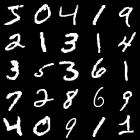

In [8]:
transforms.ToPILImage()(
    torch.transpose(
        trainset.data[:25].view(5, 5, 28, 28),
        1, 2
    ).reshape(140, 140)
)

In [0]:
class Reshape(nn.Module):
  def __init__(self, *shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.reshape(x.shape[0], *self.shape)


model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5), # 1x28x28 -> 16x24x24
    nn.MaxPool2d(kernel_size=2), # -> 16x12x12
    nn.ReLU(),
    nn.Dropout(p=0.1),
    
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # -> 32x8x8
    nn.MaxPool2d(kernel_size=2), # -> 32x4x4
    nn.ReLU(),
    nn.Dropout(p=0.1),
    
    Reshape(512),
    nn.Linear(in_features=512, out_features=128),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(in_features=128, out_features=10)
).to(device)

for layer in model.children():
  if hasattr(layer, 'weight'):
    nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))


loss_function = nn.CrossEntropyLoss()

learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
from IPython.display import clear_output

class Logger:
  def __init__(self):
    self.train_loss_batch = []
    self.train_loss_epoch = []
    self.train_metrics_batch = {}
    self.test_loss_batch = []
    self.test_loss_epoch = []
    self.test_metrics_batch = {}
    self.train_batches_per_epoch = 0
    self.test_batches_per_epoch = 0
    self.epoch_counter = 0

  def fill_train(self, loss, **other_metrics):
    self.train_loss_batch.append(loss)
    self.train_batches_per_epoch += 1
    for k, v in other_metrics.items():
      self.train_metrics_batch.setdefault(k, []).append(v)

  def fill_test(self, loss, **other_metrics):
    self.test_loss_batch.append(loss)
    self.test_batches_per_epoch += 1
    for k, v in other_metrics.items():
      self.test_metrics_batch.setdefault(k, []).append(v)

  def finish_epoch(self):
    self.train_loss_epoch.append(np.mean(
        self.train_loss_batch[-self.train_batches_per_epoch:]
    ))
    self.test_loss_epoch.append(np.mean(
        self.test_loss_batch[-self.test_batches_per_epoch:]
    ))
    self.train_batches_per_epoch = 0
    self.test_batches_per_epoch = 0
    
    clear_output()
  
    print("epoch #{} \t train_loss: {:.8} \t test_loss: {:.8}".format(
              self.epoch_counter,
              self.train_loss_epoch[-1],
              self.test_loss_epoch [-1]
          ))
    for k, v in self.train_metrics_batch.items():
      print("           \t train_{}: {:.4} \t test_{} {:.4}".format(
                k, np.mean(v),
                k, np.mean(self.test_metrics_batch[k])
            ))
    self.train_metrics_batch = {}
    self.test_metrics_batch = {}
    
    self.epoch_counter += 1

    plt.figure(figsize=(11, 5))

    plt.subplot(1, 2, 1)
    plt.plot(self.train_loss_batch, label='train loss')
    plt.xlabel('# batch iteration')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(self.train_loss_epoch, label='average train loss')
    plt.plot(self.test_loss_epoch , label='average test loss' )
    plt.legend()
    plt.xlabel('# epoch')
    plt.ylabel('loss')
    plt.show();

epoch #29 	 train_loss: 0.01909059 	 test_loss: 0.021409541
           	 train_accuracy: 0.9938 	 test_accuracy 0.993


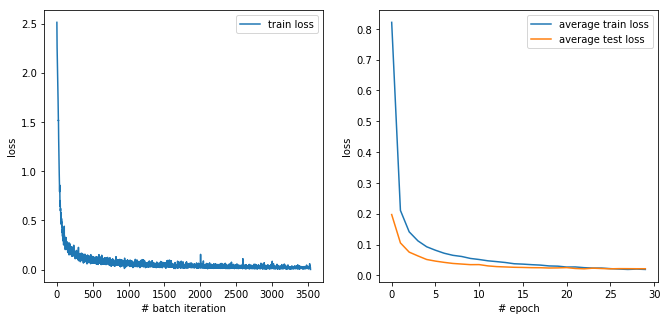

In [11]:
n_epochs = 30

logger = Logger()

for _ in range(n_epochs):
  model.train()
  for inputs, targets in trainloader:
    inputs, targets = inputs.to(device), targets.to(device)
    model.zero_grad()

    logits = model(inputs)
    loss = loss_function(logits, targets)
    
    accuracy = torch.mean((torch.argmax(logits, dim=1) == targets).float())

    loss.backward()
    optimizer.step()
    
    logger.fill_train(loss.item(), accuracy=accuracy.item())
  
  model.eval()
  with torch.no_grad():
    for inputs, targets in testloader:
      inputs, targets = inputs.to(device), targets.to(device)
      logits = model(inputs)
      loss = loss_function(logits, targets)
      
      accuracy = torch.mean((torch.argmax(logits, dim=1) == targets).float())
      
      logger.fill_test(loss.item(), accuracy=accuracy.item())

  logger.finish_epoch()
      

In [12]:
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(model, model_path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


----------------

In [0]:
model = nn.Sequential(
    nn_ard.Conv2dARD(in_channels=1, out_channels=16, kernel_size=5), # 1x28x28 -> 16x24x24
    nn.MaxPool2d(kernel_size=2), # -> 16x12x12
    nn.ReLU(),
    
    nn_ard.Conv2dARD(in_channels=16, out_channels=32, kernel_size=5), # -> 32x8x8
    nn.MaxPool2d(kernel_size=2), # -> 32x4x4
    nn.ReLU(),
    
    Reshape(512),
    nn_ard.LinearARD(in_features=512, out_features=128),
    nn.ReLU(),
    nn_ard.LinearARD(in_features=128, out_features=10)
).to(device)

for layer in model.children():
  if hasattr(layer, 'weight'):
    nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))

loss_function = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch #29 	 train_loss: 0.099932053 	 test_loss: 0.066077366
           	 train_accuracy: 0.9694 	 test_accuracy 0.98


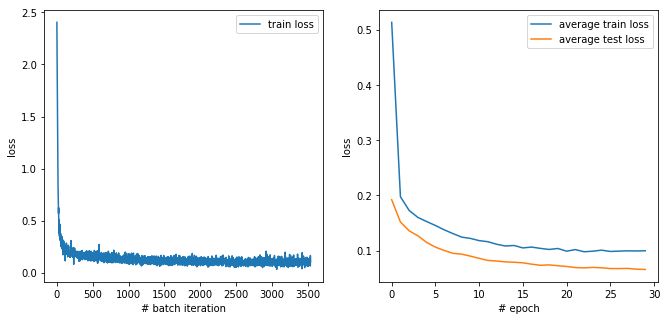

Sparsification ratio: 94.619%


In [14]:
n_epochs = 30
reg_param = 0.01

logger = Logger()

for i_epoch in range(n_epochs):
  model.train()
  for inputs, targets in trainloader:
    inputs, targets = inputs.to(device), targets.to(device)
    model.zero_grad()

    logits = model(inputs)
    loss = loss_function(logits, targets)
    
    accuracy = torch.mean((torch.argmax(logits, dim=1) == targets).float())
#    if i_epoch > 2:
    total_loss = loss + reg_param * nn_ard.get_ard_reg(model) * targets.shape[0] / len(trainset)
#    else:
#      total_loss = loss
    total_loss.backward()
    optimizer.step()
    
    logger.fill_train(loss.item(), accuracy=accuracy.item())
  
  model.eval()
  with torch.no_grad():
    for inputs, targets in testloader:
      inputs, targets = inputs.to(device), targets.to(device)
      logits = model(inputs)
      loss = loss_function(logits, targets)
      
      accuracy = torch.mean((torch.argmax(logits, dim=1) == targets).float())
      
      logger.fill_test(loss.item(), accuracy=accuracy.item())

  logger.finish_epoch()
  print('Sparsification ratio: {:.3f}%'.format(100. * nn_ard.get_dropped_params_ratio(model)))

In [15]:
model_sparse_path = 'models/sparse.pt'
torch.save(model, model_sparse_path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model_baseline_cpu = torch.load(model_path).cpu().eval()
model_baseline_gpu = torch.load(model_path).cuda().eval()

model_sparse_cpu = torch.load(model_sparse_path).cpu().eval()
model_sparse_gpu = torch.load(model_sparse_path).cuda().eval()

In [17]:
batch_X_cpu = next(iter(testloader))[0]
batch_X_gpu = next(iter(testloader))[0].cuda()

with torch.no_grad():
  start_t = time.time()
  for _ in range(50):
    logits = model_baseline_cpu(batch_X_cpu)
  time_baseline_cpu = time.time() - start_t
  
  start_t = time.time()
  for _ in range(50):
    logits = model_sparse_cpu(batch_X_cpu)
  time_sparse_cpu = time.time() - start_t
  
  start_t = time.time()
  for _ in range(50):
    logits = model_baseline_gpu(batch_X_gpu)
  time_baseline_gpu = time.time() - start_t
  
  start_t = time.time()
  for _ in range(50):
    logits = model_sparse_gpu(batch_X_gpu)
  time_sparse_gpu = time.time() - start_t

print("Baseline (CPU):", time_baseline_cpu, 'secs')
print("Sparse (CPU):  ", time_sparse_cpu  , 'secs')
print("Baseline (GPU):", time_baseline_gpu, 'secs')
print("Sparse (GPU):  ", time_sparse_gpu  , 'secs')

Baseline (CPU): 6.135144948959351 secs
Sparse (CPU):   5.779918909072876 secs
Baseline (GPU): 0.017070531845092773 secs
Sparse (GPU):   0.0607757568359375 secs
